Testing use of einsum to vectorize dW compute for the hidden layer.  

In [1]:
import numpy as np
# 2 hidden units, mini-batch has 3 teachers
D1 = np.array([[1,2],[2,4],[5,6]])
print(np.shape(D1))

(3, 2)


In [2]:
import numpy as np

W1 = np.random.uniform(size=(1,6), low=-1, high=1)
print(W1)
print(np.shape(W1))

X = np.array([[1.,1.,1.,1.,1.,1.], [2.,2.,2.,2.,2.,2.]])
print(X)
print(np.shape(X))

np.einsum('ij,kj', W1, X)

[[ 0.86333547 -0.36885022 -0.64099211  0.32580485  0.66954104 -0.74959649]]
(1, 6)
[[ 1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.]]
(2, 6)


array([[ 0.09924255,  0.19848511]])

In [3]:
#%%writefile read_data.py
#%load read_data.py
import pandas as pd
import os
def load_data(filename):
    csv_path = os.path.join(".", filename)
    return pd.read_csv(csv_path)

room_data = load_data('train_data.txt')
room_data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


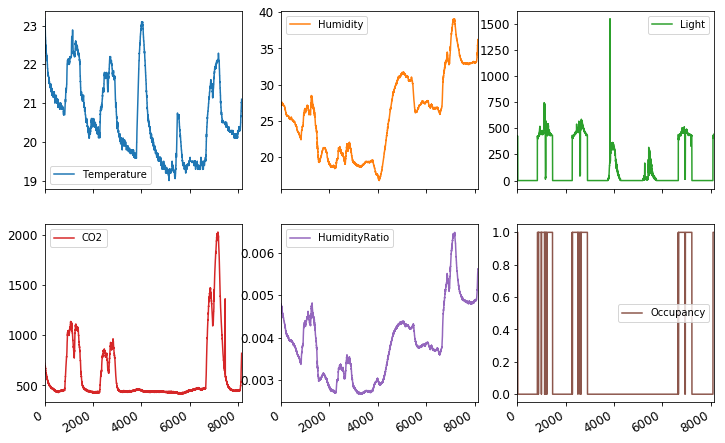

In [4]:
#%%writefile plot_data.py
#%load plot_data.py
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
room_data.plot(subplots=True, layout=(2,3), figsize=(12, 8));

Prepared data shape (8143, 5)
          0         1         2         3         4
0  0.812227 -1.126677  1.922939  0.185980 -0.923709
1  0.233645  1.693252  1.609707  0.187040  1.754763
2 -0.412137 -0.803039 -0.613726 -0.509743 -0.882903
3 -0.117110  0.979230  1.681597  1.123773  0.919887
4  1.948083  0.306490 -0.613726  0.163708  0.927153


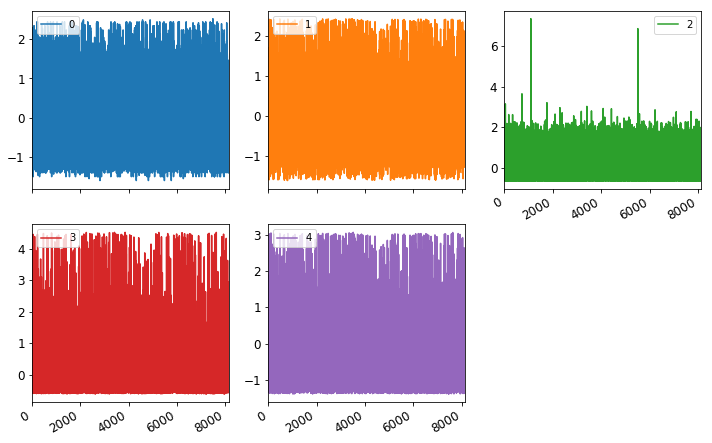

In [9]:
#%%writefile preprocess_data.py
#%load preprocess_data.py

from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import re
room_data.describe()

#attributes = [attr for attr in list(data) if not re.search(attr, r'date|Occupancy')]
# Create a class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# list of attributes for the DataFrameSelector (pandas to numpy)
room_attrib = [attr for attr in list(room_data) if not re.search(attr, r'date|Occupancy')]
pipeline = Pipeline([
    ('selector', DataFrameSelector(room_attrib)),
    ('std_scaler', StandardScaler()),
])

room_prepared = pipeline.fit_transform(room_data)
print(f"Prepared data shape {np.shape(room_prepared)}")
#print(room_prepared[0])
df = pd.DataFrame(room_prepared)
# shuffle the normalized data with stable seed (repoducable debug)
df = df.sample(frac=1, random_state=0).reset_index(drop=True)
print(df.head(5))
df.plot(subplots=True, layout=(2,3), figsize=(12, 8));



In [10]:
# %load mlp_train.py
import os as os
import numpy as np
import scipy.io
import scipy.optimize as optimization

def add_bias(X):
    bias = np.full((np.shape(X)[0],
                    np.shape(X)[1]+1), 1.0)
    bias[:,1:] = X
    return bias

#debug = True
debug = False

def forward_propagation(T, X, W1, W2):
    if debug : print(f"W1 shape is {np.shape(W1)}")
    if debug : print(f"W2 shape is {np.shape(W2)}")
    if debug : print(f"X shape is {np.shape(X)}")
    if debug : print(f"T shape is {np.shape(X)}")
    # X has shape (n_batch x n_input)
    # 'ij,kj' is W*XT and then ->ki transposes the output
    # so we end up with column-wise activations.
    #Z1 = add_bias(np.einsum('ij,kj->ki',W1,X))
    Z1 = np.einsum('ij,kj->ki',W1,X)
    Y1 = np.tanh(Z1)
    if debug : print(f"Y1 shape is {np.shape(Y1)}")
    Y1B = add_bias(Y1)
    Z2 = np.einsum('ij,kj->ki', W2, Y1B)
    Y2 = np.tanh(Z2)
    if debug : print(f"Y2 shape is {np.shape(Y2)}")
    if debug : print(f"T shape is {np.shape(T)}")
    # ouptut layer
    # * for numpy (n,) is element wise (T-Y)*(1-Y)*(1+Y)
    R = (T-Y2) # residual
    D2 = R * (np.ones(np.shape(T)) + Y2) * (np.ones(np.shape(T)) - Y2)
    # einsum for dot product (overkill - LOL)
    E = (1.0/float(len(R))) * np.einsum('ij,ij', R,R)
    if debug : print(f"D2 shape is {np.shape(D2)}")
    # W2 slice that excludes the last element
    # since don't need D (delta) for bias at layer 1
    #
    # In other words -- there is no matrix element that
    # connects the input (layer 0) to the bias (layer 1)
    D1 = W2[:,:-1] * (1 + Y1) * (1 - Y1)
    if debug : print(f"D1 shape is {np.shape(D1)}")
    # Z0 is just the inputs with bias (i.e. X) - but this keeps
    # the notation consistent
    Z0 = X
    return E, D1, Z0, D2, Z1

def back_propagation(D2, Z1, D1, Z0, eps):
    dW2 = eps*np.einsum('ij,ij->j', D2, add_bias(Z1));
    if debug : print(f"dW2 shape is {np.shape(dW2)}")
    # outer product ij,ik-jk where the first index that represents
    # the sample label in the mini-batch is summed over
    dW1 = eps*np.einsum('ij,ik->jk', D1, Z0);
    if debug : print(f"dW1 shape is {np.shape(dW1)}")
    return dW1, dW2

def mlp_train(*, n_epoch, minibatch_size, learning_rate, n_hidden):
    # fix the seed for stable debugging
    np.random.seed(0)
    # data
    # shape is (nrow, 6)
    X = add_bias(room_prepared)
    # number of inputs
    n_input = np.shape(X)[1]
    # use domain -1,1 for teachers for tanh activation
    # shape is (nrow,1)
    T = np.array([z if z == 1 else -1 for z in room_data['Occupancy']])
    T = T.reshape(len(T),1)
    # number of outputs
    n_output = 1
    # starting matrix of weights for input layer, shape is (6 x n_hidden)
    # shape is n_outputs x n_inputs
    # equivalent to: ncol == n_input, n_row == n_output (or n_hidden)
    W1 = np.random.uniform(size=(n_hidden, n_input), low=-1, high=1)
    if debug : print(f"W1 shape is {np.shape(W1)}")
    # starting matrix of weights for hidden layer
    # shape is (n_output, n_hidden+1), +1 in first dim is for hidden layer bias
    W2 = np.random.uniform(size=(n_output, n_hidden+1), low=-1, high=1)
    if debug : print(f"W2 shape is {np.shape(W2)}")
    # minibatch processing
    XBS = np.array_split(X, np.ceil(len(X)/minibatch_size))
    TBS = np.array_split(T, np.ceil(len(T)/minibatch_size))

    for j in range(n_epoch):
        for i in range(len(XBS)):
            XB = XBS[i]
            TB = TBS[i]
            EB, D1, Z0, D2, Z1 = forward_propagation(TB, XB, W1, W2)
            #print(EB)
            dW1, dW2 = back_propagation(D2, Z1, D1, Z0, learning_rate)
            W1 += dW1
            W2 += dW2

        E, _, _, _, _ = forward_propagation(T, X, W1, W2)
        print(E)

    # weights, performance
    return 0, 0

# invoke main
w_trained, performance = mlp_train(n_epoch=10,
                                   minibatch_size=8143,
                                   learning_rate=0.0001,
                                   n_hidden=3)

1.48786415239
1.35553319658
0.620122584976
0.378166589359
0.473343067154
0.511805939102
0.579202353264
0.611227192431
0.650978295147
0.673821929757


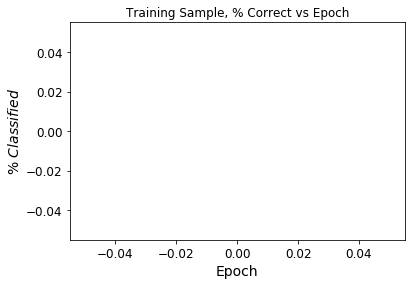

In [7]:
#%%writefile plot_train_perf.py
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.ylabel(r'$\%\ Classified$')
plt.xlabel('Epoch')
plt.title('Training Sample, % Correct vs Epoch')
plt.plot(performance)

In [8]:
%%writefile mlp_test.py
def mlp_test(w):

test(w_trained)

Overwriting mlp_test.py
